# FED3 Analysis Pipeline

This notebook demonstrates a reusable workflow for loading FED3 sample sessions, running quality checks, and generating FR1 analyses.

## Step 1: Import Required Libraries

This cell imports all necessary Python libraries and helper functions from the `scripts/` folder. These include:
- **Data handling**: pandas, numpy
- **Visualization**: matplotlib
- **Custom modules**: preprocessing, accuracy, meals, direction_transition, and statistical utilities

All warnings are suppressed for cleaner output.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.preprocessing import build_session_catalog, session_cache, motor_turn_summary
from scripts.accuracy import read_and_record, plot_cumulative_accuracy
from scripts.utils import (
    perform_T_test,
    graph_group_stats,
    run_pairwise_tests,
    plot_group_stats_wrapper,
    collect_metric,
)
from scripts.meals import process_meal_data, find_meals_paper, collect_good_meal_ratio
from scripts.direction_transition import (
    split_data_to_blocks,
    get_transition_info,
    first_meal_stats,
    learning_result,
    learning_score,
    plot_learning_score_trend,
    plot_pellet_ratio_trend,
    plot_transition_stats,
    block_retrieval_summary,
    plot_retrieval_time_by_block,
)
import warnings
warnings.filterwarnings("ignore")

## Step 2: Configure Paths and Load Session Data

This cell performs the initial setup:

1. **Define paths**: Sets up directories for input data (`sample_data`), group configuration (`group_map.json`), and output figures (`figures`).
2. **Build session catalog**: Scans the data directory and organizes all sessions by:
   - Mouse ID
   - Session type (FR1 for fixed-ratio, REV for reversal)
   - Group membership (from group_map.json)
3. **Prepare test pairs**: If you have 2+ groups, statistical comparisons will be run between the first two groups.

**What you get**:
- `SESSIONS`: Dictionary mapping session IDs to session data objects
- `GROUPINGS`: Dictionary organizing sessions by group and session type
- `GROUP_SESSIONS`: Simplified view showing which session IDs belong to each group/type


In [2]:
SAMPLE_ROOT = Path("sample_data")
GROUP_MAP_PATH = Path("group_map.json")
FIGURE_ROOT = Path("figures")
FIGURE_ROOT.mkdir(exist_ok=True)

session_cache.cache_clear()
SESSIONS, GROUPINGS = build_session_catalog(SAMPLE_ROOT, GROUP_MAP_PATH)
GROUP_NAMES = list(GROUPINGS.keys())
GROUP_SESSIONS = {
    group: {stype: [key.session_id for key in mapping] for stype, mapping in session_types.items()}
    for group, session_types in GROUPINGS.items()
}
GROUPS = list(GROUP_SESSIONS.keys())
TEST_PAIRS = [(GROUPS[0], GROUPS[1])] if len(GROUPS) >= 2 else []

## Step 3: Data Quality Control - Check Dispenser Performance

This cell performs a critical quality control step by examining the FED3 hardware performance:

**What it does**:
- For each session, counts how many times the stepper motor rotated ≥15 times during pellet dispensing
- This is a proxy for mechanical errors or jams
- Sessions where >20% of pellet events show excessive motor turns are flagged

**Why it matters**:
Mechanical issues can lead to:
- Inaccurate pellet counts
- Frustrated animals
- Skewed behavioral metrics

**Result**: 
- Problematic sessions are displayed in a summary table
- These sessions are automatically removed from `SESSIONS` and `GROUP_SESSIONS` to ensure clean downstream analyses


In [3]:
dispense_rows = []
for session in SESSIONS.values():
    cnt, prop = motor_turn_summary(session.key.session_path)
    dispense_rows.append(
        {
            "session_id": session.key.session_id,
            "mouse_id": session.key.mouse_id,
            "group": session.key.group,
            "session_type": session.key.session_type,
            "exceeding_cnt": cnt,
            "proportion": prop,
        }
    )
dispense_df = (
    pd.DataFrame(dispense_rows)
    .sort_values(["group", "mouse_id", "session_id"])
    .reset_index(drop=True)
)
removed_sessions = dispense_df[dispense_df["proportion"] > 0.2]
print("Dispense quality summary:")
print(removed_sessions)

for idx, row in removed_sessions.iterrows():
    _ = SESSIONS.pop(row['session_id'])
    GROUP_SESSIONS[row['group']][row['session_type']].remove(row['session_id'])

Dispense quality summary:
    session_id mouse_id   group session_type  exceeding_cnt  proportion
117    M68_fr1      M68  female          FR1             34    0.314815
129    M74_fr1      M74  female          FR1             16    0.533333


---

# Part A: FR1 (Fixed-Ratio 1) Analysis

## Step 4: Process FR1 Sessions and Compute Learning Metrics

**What is FR1?**  
In a Fixed-Ratio 1 schedule, every correct poke delivers one pellet immediately. This tests basic learning acquisition.

**This cell**:
1. Extracts all FR1 sessions for each group
2. For each session, calculates:
   - **Ending accuracy**: Final performance level
   - **Learning time**: When the mouse first reaches 80% accuracy
3. Generates cumulative accuracy plots showing learning curves over time (binned into 5-second intervals)

**Outputs**:
- `fr1_dataframes`: Raw session data per group
- `fr1_end_accuracy`: Final accuracy scores for each mouse
- `fr1_learn_time`: Time to reach 80% accuracy milestone
- **Figure**: `cumulative_accuracy.svg` showing group learning curves with error bands


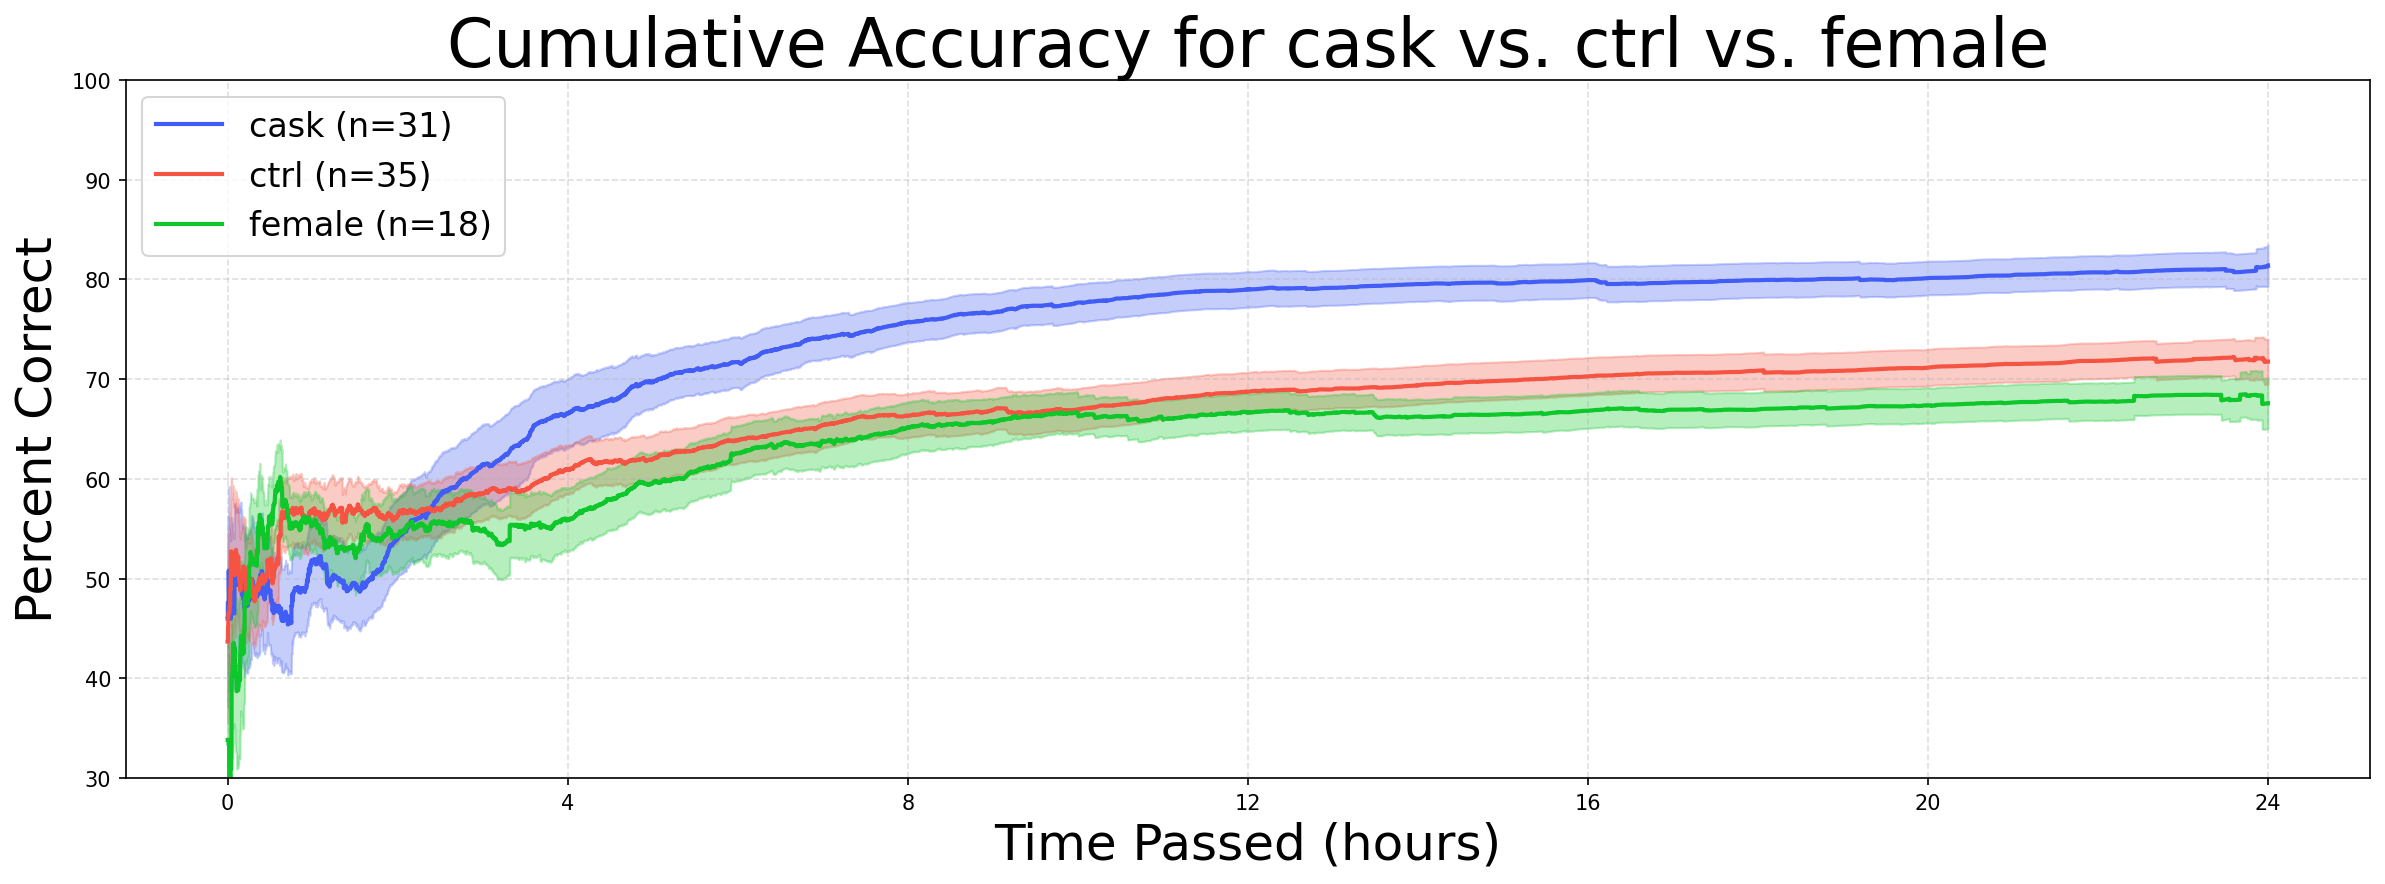

In [4]:
fr1_group_sessions = {
    group: [SESSIONS[sid] for sid in sessions_by_type["FR1"]]
    for group, sessions_by_type in GROUP_SESSIONS.items()
}
fr1_dataframes = {}
fr1_end_accuracy = {}
fr1_learn_time = {}
for group, sessions in fr1_group_sessions.items():
    dfs = []
    ending, learned, sheet_acc = [], [], {}
    for session in sessions:
        df = read_and_record(session, ending, learned, sheet_acc)
        dfs.append(df)
    fr1_dataframes[group] = dfs
    fr1_end_accuracy[group] = ending
    fr1_learn_time[group] = learned

fr1_figure_dir = FIGURE_ROOT / "FR1"
fr1_figure_dir.mkdir(parents=True, exist_ok=True)
labels = list(fr1_dataframes.keys())
plot_cumulative_accuracy(
    [fr1_dataframes[label] for label in labels],
    group_labels=labels,
    bin_size_sec=5,
    export_path=str(fr1_figure_dir / "cumulative_accuracy.svg"),
)

## Step 5: Visualize FR1 Learning Performance

This cell creates statistical visualizations and runs hypothesis tests:

**Generates**:
1. **Overall Accuracy plot**: Distribution of final accuracy scores across groups (with outlier removal at 2.5 std)
2. **Learning Milestone plot**: Time taken to reach 80% accuracy
3. **Statistical tests**: Pairwise t-tests comparing groups (if TEST_PAIRS is defined)

**Note**: The `remove_outlier_stds=2.5` parameter removes extreme values >2.5 standard deviations from the mean to prevent a few anomalous sessions from skewing the visualization (original data is preserved for statistical tests). You can adjust the outlier threshold on your own.

cask Size: 30 	 Average: 82.362 	 SE: 1.457
ctrl Size: 34 	 Average: 73.759 	 SE: 1.558
female Size: 17 	 Average: 68.245 	 SE: 1.800


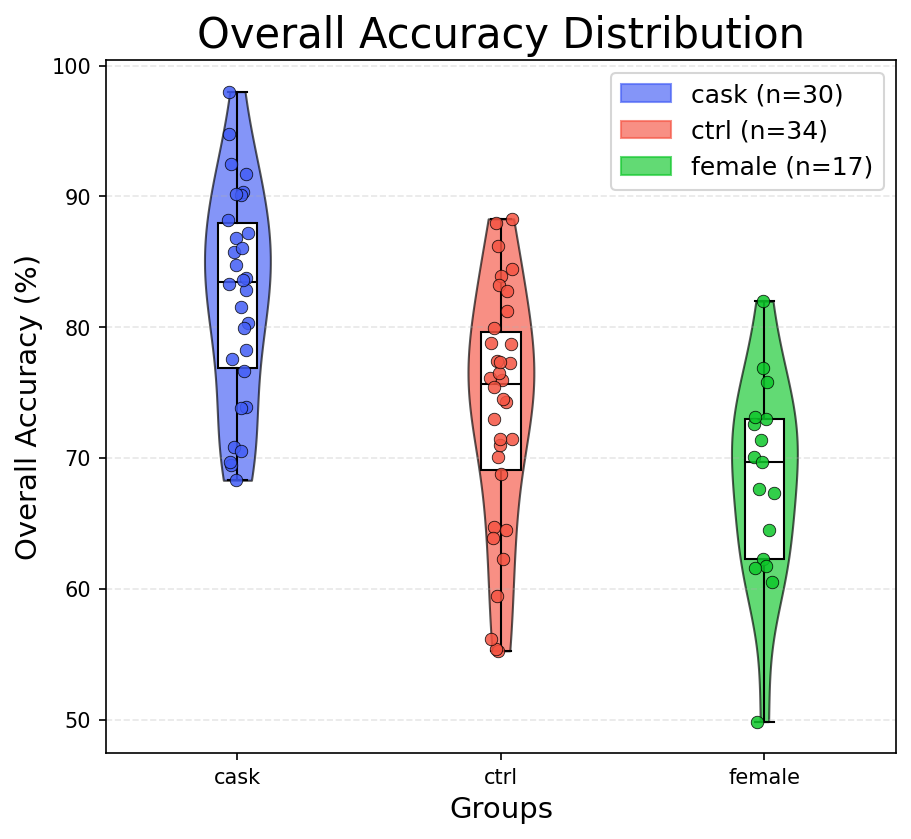

cask Size: 30 	 Average: 1.878 	 SE: 0.265
ctrl Size: 35 	 Average: 4.387 	 SE: 0.620
female Size: 17 	 Average: 4.641 	 SE: 0.573


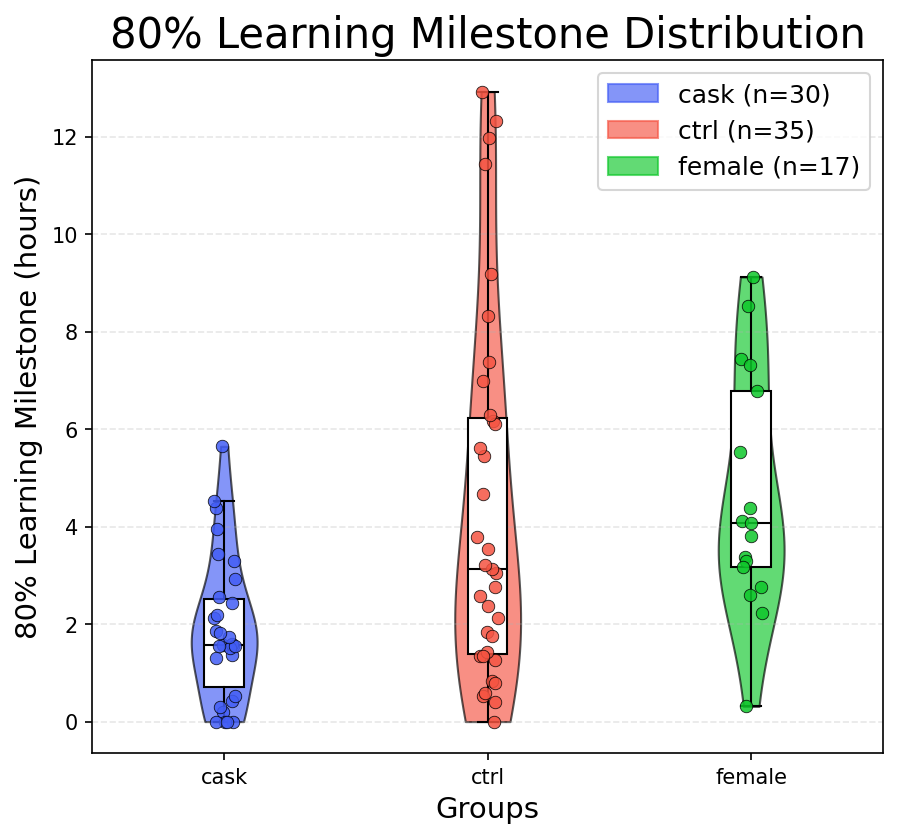

In [ ]:
plot_group_stats_wrapper(fr1_end_accuracy, "Overall Accuracy", "%", "overall_accuracy.svg", fr1_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(fr1_learn_time, "80% Learning Milestone", "hours", "learning_milestone_time.svg", fr1_figure_dir, remove_outlier_stds=2.5)

perform_T_test()

## Step 6: Analyze FR1 Meal Patterns

**What are meals?**  
A "meal" is a burst of pellets consumed close together in time (default: <60 seconds apart, ≥2 pellets). This cell uses both traditional meal detection and a trained neural network classifier to assess meal quality.

**For each FR1 session, this computes**:
1. **Average pellets per hour**: Overall consumption rate
2. **First meal time**: Latency to start feeding
3. **First good meal time**: When the mouse has its first high-quality meal (per ML model)
4. **In-meal pellet ratio**: What fraction of pellets occurred inside meals vs scattered eating
5. **Good meal proportion**: Ratio of ML-classified "good" vs "bad" meals

**Outputs**:
- Multiple metrics dictionaries organized by group
- Per-session diagnostic plots saved to `figures/FR1/meals/`:
  - Pellet frequency histograms
  - Cumulative pellet plots with meal periods highlighted


In [6]:
meal_dir = fr1_figure_dir / "meals"
meal_dir.mkdir(parents=True, exist_ok=True)
fr1_meal_metrics = {group: [] for group in labels}
fr1_meal_quality = {group: [] for group in labels}
for group, sessions in fr1_group_sessions.items():
    for session in sessions:
        metrics = process_meal_data(session, export_root=meal_dir)
        fr1_meal_metrics[group].append(metrics)
        fr1_meal_quality[group].append({
            'good_mask': metrics.get('good_mask'),
            'total_meals': metrics.get('total_meals'),
        })

avg_pellet = collect_metric("avg_pellet", fr1_meal_metrics)
first_meal_time = collect_metric("fir_meal", fr1_meal_metrics)
first_good_meal_time = collect_metric("fir_good_meal", fr1_meal_metrics)
in_meal_ratio = collect_metric("in_meal_ratio", fr1_meal_metrics)
fr1_good_meal_ratio = collect_good_meal_ratio(fr1_meal_quality)

good_meal_ratio_summary = {
    group: {
        'mean': float(np.mean(values)) if values else 0.0,
        'std': float(np.std(values)) if values else 0.0,
    }
    for group, values in fr1_good_meal_ratio.items()
}

run_pairwise_tests(fr1_end_accuracy, "Overall Accuracy", TEST_PAIRS)
run_pairwise_tests(fr1_learn_time, "80% Learning Milestone", TEST_PAIRS)


[T-test] Overall Accuracy: cask vs ctrl
P Value is  0.0011517720576340522
[T-test] 80% Learning Milestone: cask vs ctrl
P Value is  0.004973404915244425


## Step 7: Visualize and Test FR1 Meal Metrics

This cell creates violin plots for all meal-related metrics computed in the previous step and runs statistical comparisons between groups.

**Generates 5 figures**:
1. Average pellets per hour
2. First meal latency
3. First good meal latency
4. In-meal pellet ratio (organized vs scattered eating)
5. Good meal proportion

**Statistical tests**: For each metric, runs independent t-tests between group pairs to assess significance.

All figures are saved to `figures/FR1/` and displayed inline.


cask Size: 30 	 Average: 247.340 	 SE: 6.596
ctrl Size: 34 	 Average: 232.428 	 SE: 5.072
female Size: 17 	 Average: 209.301 	 SE: 8.302


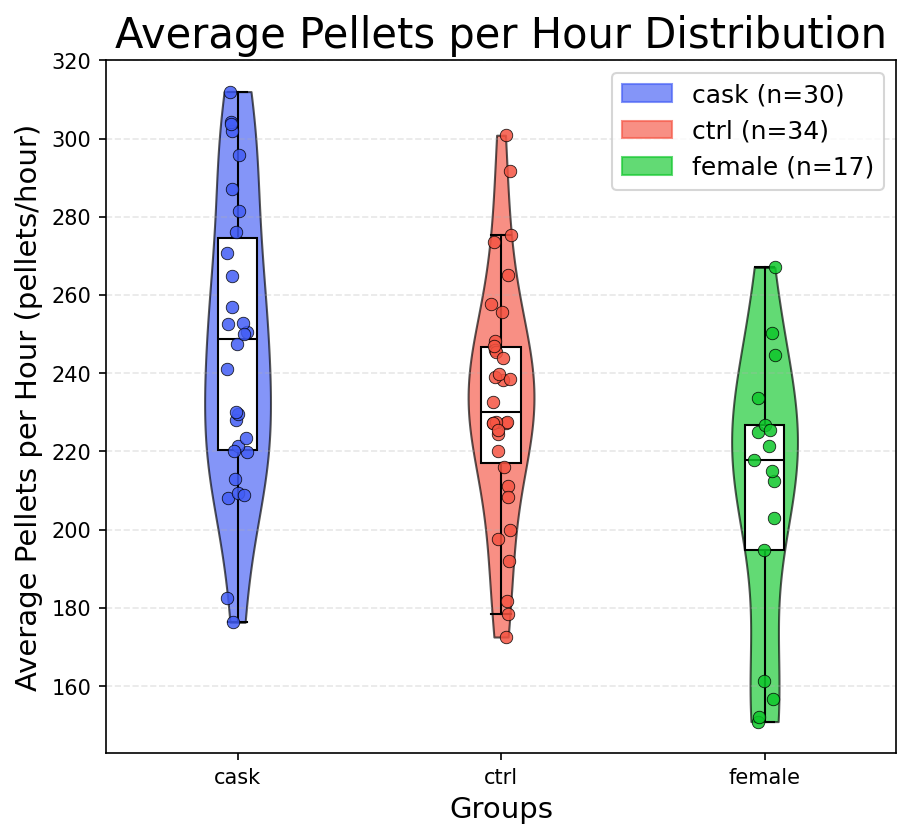

cask Size: 30 	 Average: 1.859 	 SE: 0.207
ctrl Size: 34 	 Average: 2.064 	 SE: 0.153
female Size: 18 	 Average: 2.070 	 SE: 0.269


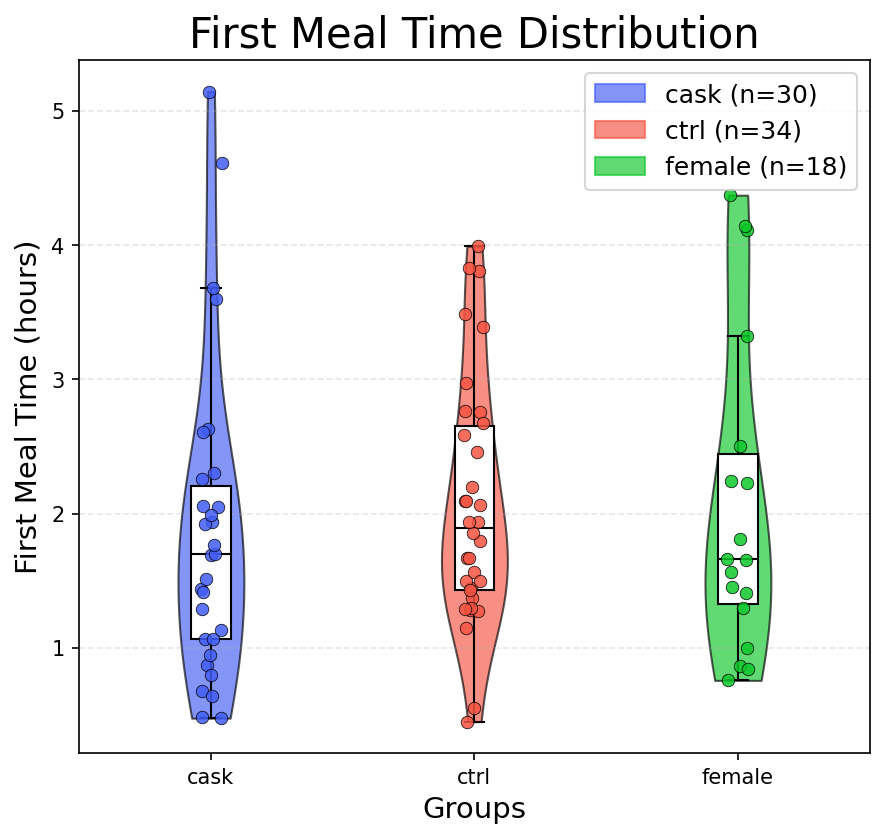

cask Size: 30 	 Average: 2.756 	 SE: 0.248
ctrl Size: 34 	 Average: 2.791 	 SE: 0.204
female Size: 17 	 Average: 2.951 	 SE: 0.288


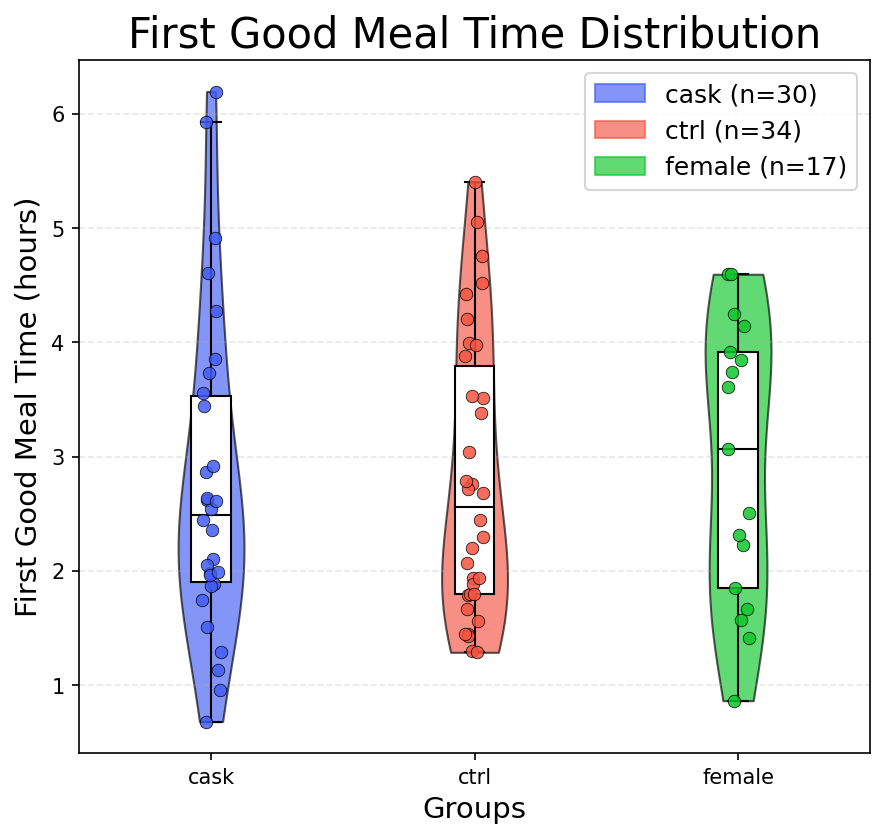

cask Size: 30 	 Average: 0.764 	 SE: 0.012
ctrl Size: 34 	 Average: 0.726 	 SE: 0.011
female Size: 18 	 Average: 0.603 	 SE: 0.020


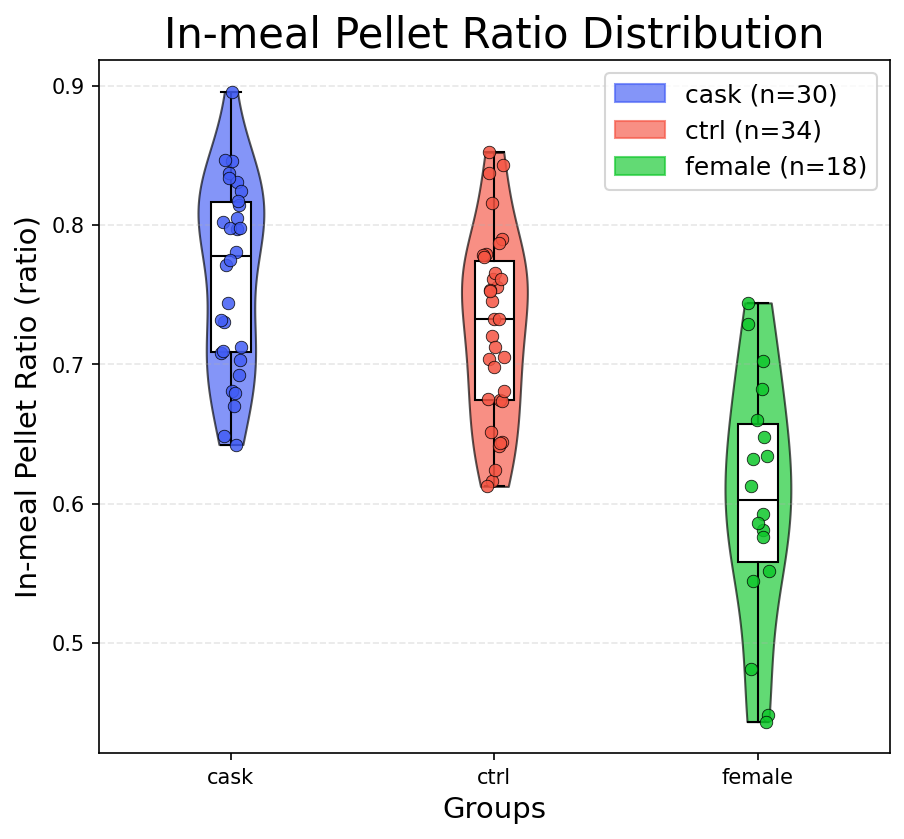

cask Size: 31 	 Average: 0.547 	 SE: 0.028
ctrl Size: 35 	 Average: 0.612 	 SE: 0.023
female Size: 18 	 Average: 0.532 	 SE: 0.032


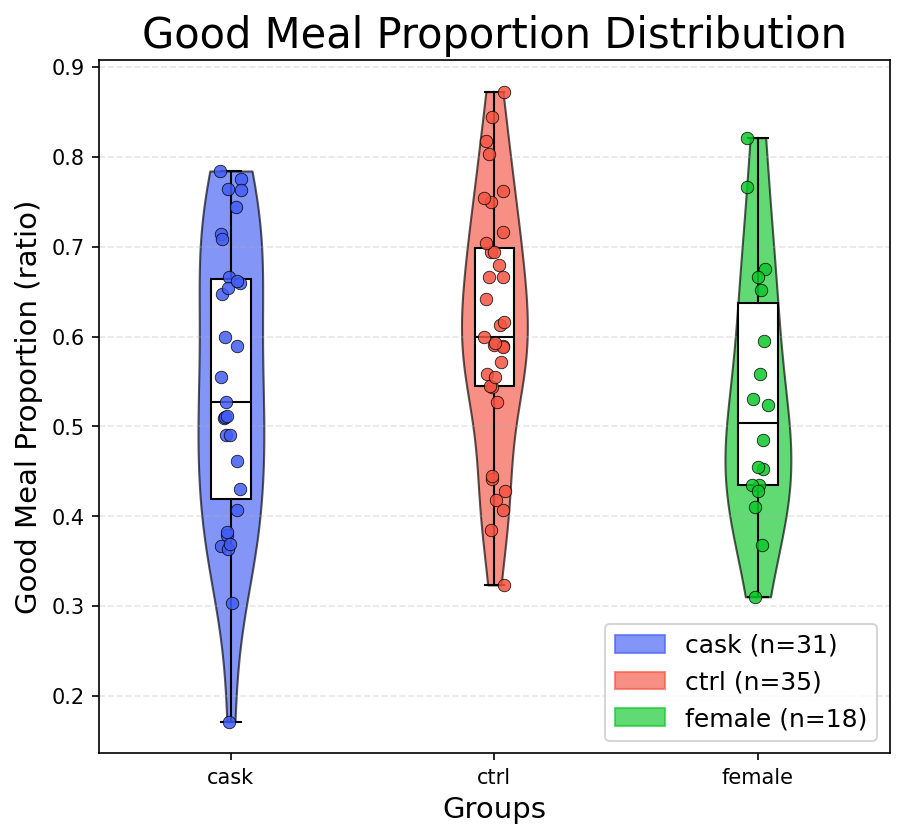

[T-test] Average Pellets per Hour: cask vs ctrl
P Value is  0.09950914475032482
[T-test] First Meal Time: cask vs ctrl
P Value is  0.5705909288272619
[T-test] First Good Meal Time: cask vs ctrl
P Value is  0.8934574260704268
[T-test] In-meal Pellet Ratio: cask vs ctrl
P Value is  0.07874060031326241
[T-test] Good Meal Proportion: cask vs ctrl
P Value is  0.08302349396552032


In [7]:
plot_group_stats_wrapper(avg_pellet, "Average Pellets per Hour", "pellets/hour", "avg_pellets.svg", fr1_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(first_meal_time, "First Meal Time", "hours", "first_meal_time.svg", fr1_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(first_good_meal_time, "First Good Meal Time", "hours", "first_good_meal_time.svg", fr1_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(in_meal_ratio, "In-meal Pellet Ratio", "ratio", "in_meal_ratio.svg", fr1_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(fr1_good_meal_ratio, "Good Meal Proportion", "ratio", "good_meal_ratio.svg", fr1_figure_dir, remove_outlier_stds=2.5)

run_pairwise_tests(avg_pellet, "Average Pellets per Hour", TEST_PAIRS)
run_pairwise_tests(first_meal_time, "First Meal Time", TEST_PAIRS)
run_pairwise_tests(first_good_meal_time, "First Good Meal Time", TEST_PAIRS)
run_pairwise_tests(in_meal_ratio, "In-meal Pellet Ratio", TEST_PAIRS)
run_pairwise_tests(fr1_good_meal_ratio, "Good Meal Proportion", TEST_PAIRS)


---

# Part B: Reversal Learning Analysis

## Step 8: Setup Reversal Session Analysis

**What is Reversal Learning?**  
After mice learn the initial FR1 task, the "correct" poke side periodically switches. This tests cognitive flexibility and adaptation.

**This cell**:
1. Filters sessions to include only reversal (REV) sessions
2. Defines analysis parameters:
   - `REV_DAY_LIMIT = 3`: Only analyze the first 3 days of reversal data
   - `REV_MEAL_CONFIG = (60, 2)`: Meal detection uses 60-second threshold and minimum 2 pellets
3. Organizes sessions by group for downstream analysis

**Output**: `rev_group_sessions` dictionary ready for block-based analyses.


In [8]:
rev_figure_dir = FIGURE_ROOT / "REV"
rev_figure_dir.mkdir(parents=True, exist_ok=True)

REV_DAY_LIMIT = 3
REV_MEAL_CONFIG = (60, 2)

rev_group_sessions = {
    group: [SESSIONS[sid] for sid in sessions_by_type.get("REV", [])]
    for group, sessions_by_type in GROUP_SESSIONS.items()
}
rev_group_sessions = {g: s for g, s in rev_group_sessions.items() if s}

## Step 9: Compute Block Transition Statistics

**What are blocks?**  
Each "block" represents a continuous period where the active poke stays on the same side. When the active side switches, a new block begins.

**This cell**:
1. Splits each reversal session into blocks.
2. For each block, calculates:
   - **Transition patterns**: Left→Left, Left→Right, Right→Right, Right→Left frequencies
   - **Success rate**: % of pokes on the correct side
   - **First meal time**: Latency to first meal within the block
   - **First good meal time**: Latency to first quality meal (ML-classified)
   - **Meal accuracy**: Average accuracy of meals in the block
3. Generates per-mouse transition plots showing:
   - Success rates across blocks (bar plot)
   - Transition percentages (line plots)
   - First good meal timing (annotated on bars)
   - Inactive periods (shaded regions)

**Outputs**:
- `rev_transition_metrics`: Dictionary of summary metrics per group
- Individual mouse figures saved to `figures/REV/transition/`


In [9]:
rev_transition_metrics = {
    "num_blocks": {g: [] for g in rev_group_sessions},
    "first_good_time": {g: [] for g in rev_group_sessions},
    "first_ratio": {g: [] for g in rev_group_sessions},
    "meal_accuracy": {g: [] for g in rev_group_sessions},
}

rev_transition_exports = []
transition_dir = rev_figure_dir / "transition"
transition_dir.mkdir(parents=True, exist_ok=True)

for group, sessions in rev_group_sessions.items():
    for session in sessions:
        data = session.raw.copy()
        blocks = split_data_to_blocks(data, day=REV_DAY_LIMIT)
        if not blocks:
            continue

        stats = get_transition_info(blocks, list(REV_MEAL_CONFIG), reverse=False)
        ratio, _, good_time = first_meal_stats(stats, ignore_inactive=True)

        rev_transition_metrics["num_blocks"][group].append(len(blocks))
        rev_transition_metrics["first_good_time"][group].append(float(good_time))
        rev_transition_metrics["first_ratio"][group].append(float(ratio))

        meal_acc = []
        for block in blocks:
            _, block_acc = find_meals_paper(
                block,
                time_threshold=REV_MEAL_CONFIG[0],
                pellet_threshold=REV_MEAL_CONFIG[1],
            )
            meal_acc.extend(block_acc)

        if meal_acc:
            rev_transition_metrics["meal_accuracy"][group].append(float(np.mean(meal_acc)))

        export_path = transition_dir / f"{group.lower()}_{session.key.session_id}_transition.svg"
        plot_transition_stats(
            stats,
            blocks,
            mouse_label=session.key.mouse_id,
            group_label=group,
            export_path=export_path,
            show=False,
        )
        rev_transition_exports.append(export_path)

## Step 10: Visualize and Test Transition Metrics

Creates group-level statistical visualizations and hypothesis tests for reversal block metrics:

**Plots generated**:
1. **Number of blocks**: How many times the active poke switched
2. **First good meal time**: How quickly mice adapted to each block switch
3. **First meal / block ratio**: Proportion of block duration before first meal
4. **Meal accuracy**: Quality of meals during reversals

**Statistical comparisons**: T-tests between group pairs for each metric.

All figures saved to `figures/REV/`.


cask Size: 24 	 Average: 27.542 	 SE: 0.705
ctrl Size: 26 	 Average: 23.692 	 SE: 0.580
female Size: 19 	 Average: 22.579 	 SE: 0.738


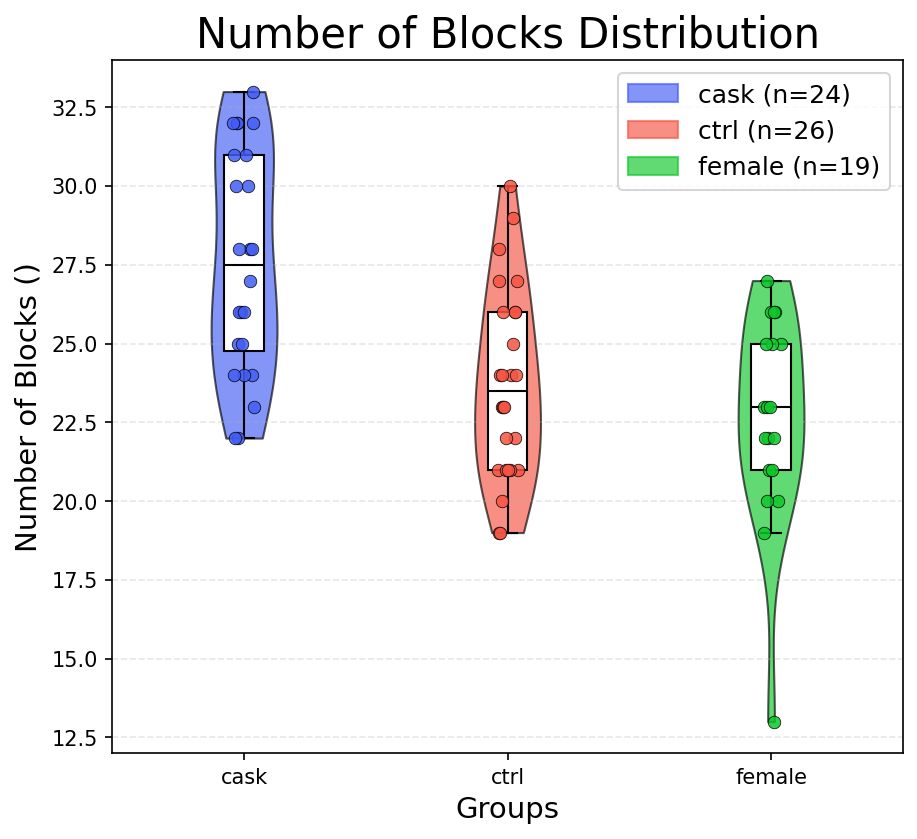

cask Size: 24 	 Average: 51.416 	 SE: 4.389
ctrl Size: 27 	 Average: 55.443 	 SE: 4.844
female Size: 19 	 Average: 75.782 	 SE: 3.541


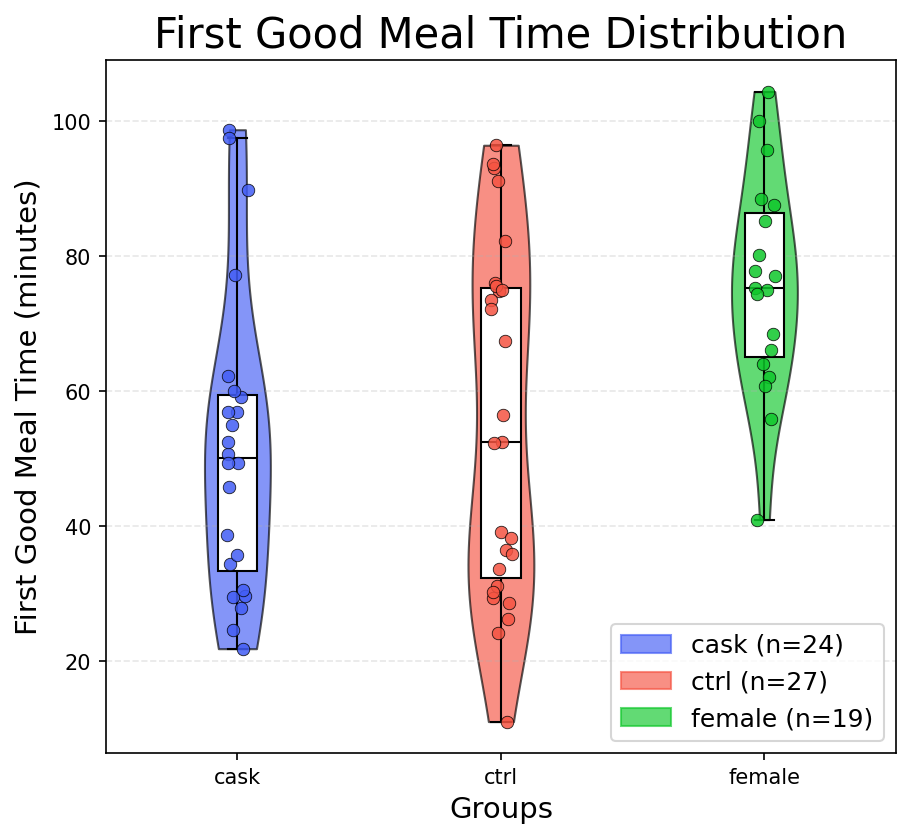

cask Size: 24 	 Average: 0.523 	 SE: 0.019
ctrl Size: 27 	 Average: 0.444 	 SE: 0.018
female Size: 19 	 Average: 0.600 	 SE: 0.019


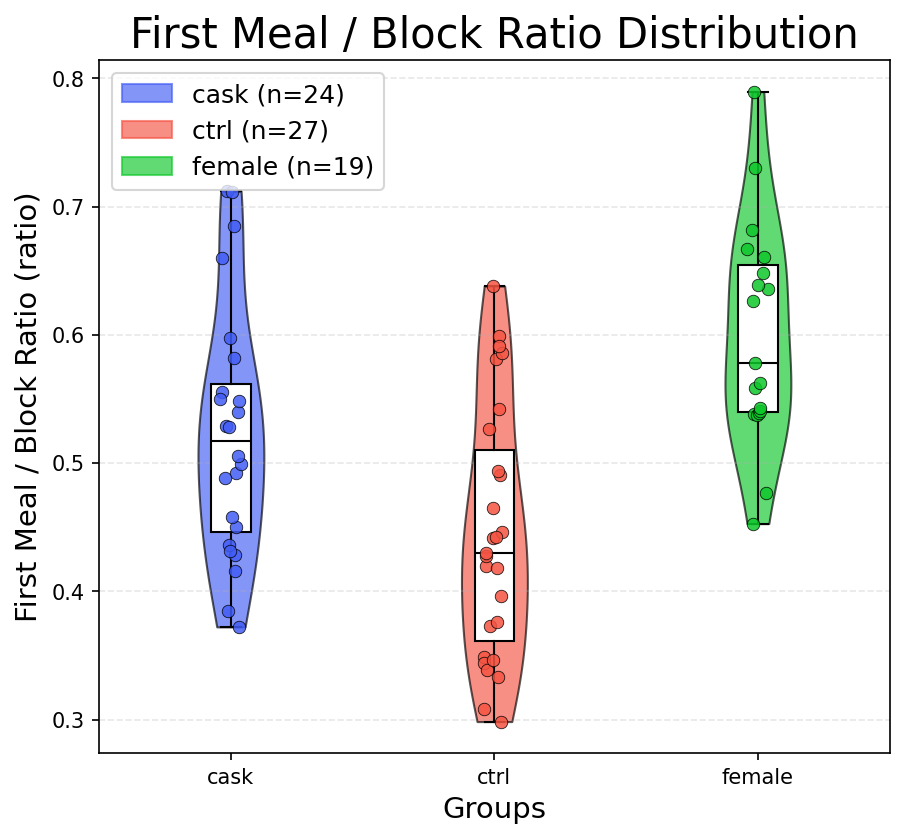

cask Size: 24 	 Average: 85.265 	 SE: 0.837
ctrl Size: 27 	 Average: 87.124 	 SE: 0.511
female Size: 20 	 Average: 85.825 	 SE: 0.638


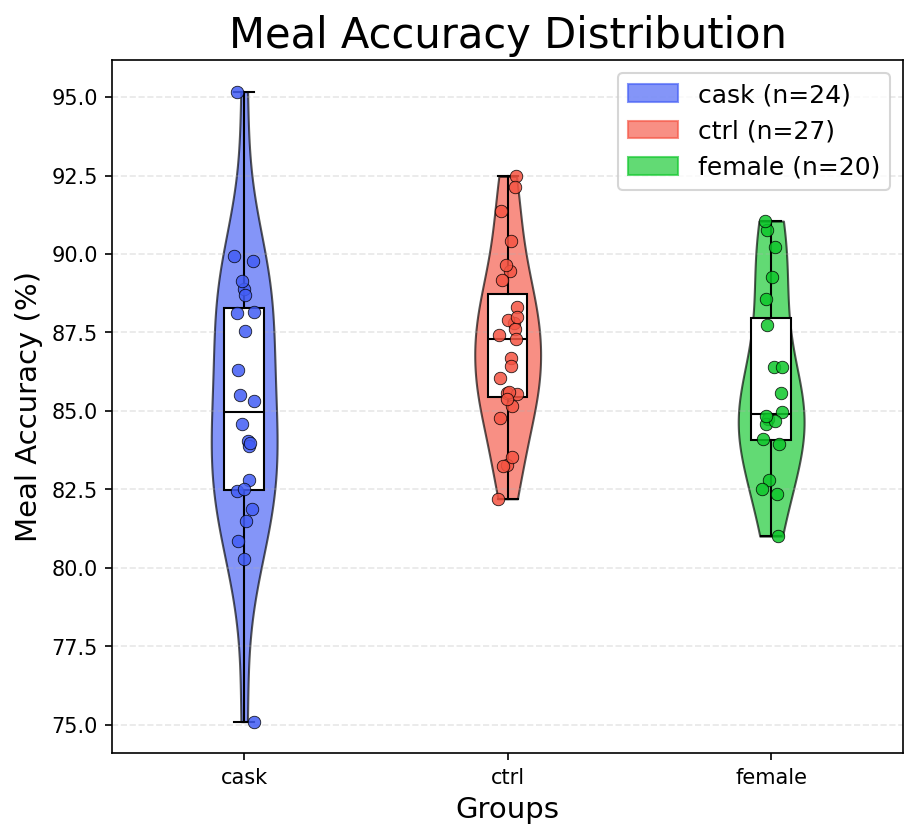

[T-test] Number of Blocks: cask vs ctrl
P Value is  0.03558858874574112
[T-test] First Good Meal Time: cask vs ctrl
P Value is  0.5524107079905747
[T-test] First Meal / Block Ratio: cask vs ctrl
P Value is  0.00595669496758611
[T-test] Meal Accuracy: cask vs ctrl
P Value is  0.06286265554075383


In [10]:
plot_group_stats_wrapper(rev_transition_metrics["num_blocks"], "Number of Blocks", "", "rev_number_of_blocks.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_transition_metrics["first_good_time"], "First Good Meal Time", "minutes", "rev_first_good_meal_time.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_transition_metrics["first_ratio"], "First Meal / Block Ratio", "ratio", "rev_first_meal_ratio.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_transition_metrics["meal_accuracy"], "Meal Accuracy", "%", "rev_meal_accuracy.svg", rev_figure_dir, remove_outlier_stds=2.5)

run_pairwise_tests(rev_transition_metrics["num_blocks"], "Number of Blocks", TEST_PAIRS)
run_pairwise_tests(rev_transition_metrics["first_good_time"], "First Good Meal Time", TEST_PAIRS)
run_pairwise_tests(rev_transition_metrics["first_ratio"], "First Meal / Block Ratio", TEST_PAIRS)
run_pairwise_tests(rev_transition_metrics["meal_accuracy"], "Meal Accuracy", TEST_PAIRS)

## Step 11: Compute Learning Scores and Results

**Learning Score**: Measures how quickly mice adapt to block switches by computing accuracy in the **first 75%** of poke events in each block.

**Learning Result**: Measures final performance by computing accuracy in the **last 25%** of poke events across all blocks.

**This cell**:
1. Stores block lists for each mouse
2. Calculates learning scores (early adaptation)
3. Calculates learning results (final performance)

These metrics help distinguish:
- Mice that learn reversals quickly vs slowly (learning score)
- Mice that maintain high accuracy vs deteriorate over time (learning result)

**Outputs**:
- `rev_learning_scores`: Per-mouse early block accuracy
- `rev_learning_results`: Per-mouse late block accuracy


In [11]:
rev_blocks = {g: [] for g in rev_group_sessions}
rev_learning_scores = {g: [] for g in rev_group_sessions}
rev_learning_results = {g: [] for g in rev_group_sessions}

for group, sessions in rev_group_sessions.items():
    for session in sessions:
        blocks = split_data_to_blocks(session.raw.copy(), day=REV_DAY_LIMIT)
        if not blocks:
            continue
        rev_blocks[group].append(blocks)

        score = learning_score(blocks, block_prop=1.0, action_prop=0.75)
        result = learning_result(blocks, action_prop=0.75)

        rev_learning_scores[group].append(float(score))
        rev_learning_results[group].append(float(result))

## Step 12: Visualize Learning Dynamics

Creates three comprehensive visualizations of reversal learning:

**1. Learning Score Trend** (`rev_learning_score_overall.svg`):
- Shows how accuracy changes across different action proportions (5% to 100% of each block)
- Separate curves for each group with SEM error bands
- Highlights the 75% proportion used for scoring

**2. Learning Result Distribution** (`rev_learning_result.svg`):
- Violin plot comparing final performance between groups
- Based on accuracy in the last 25% of each block

**3. Pellet-in-Meal Ratio Trend** (`rev_pellet_ratio_overall.svg`):
- Shows what proportion of pellets occurred within meals vs scattered eating
- Indicates whether mice maintain organized feeding behavior during reversals

**Statistical tests**: T-tests comparing groups on learning scores and results.

All figures saved to `figures/REV/`.


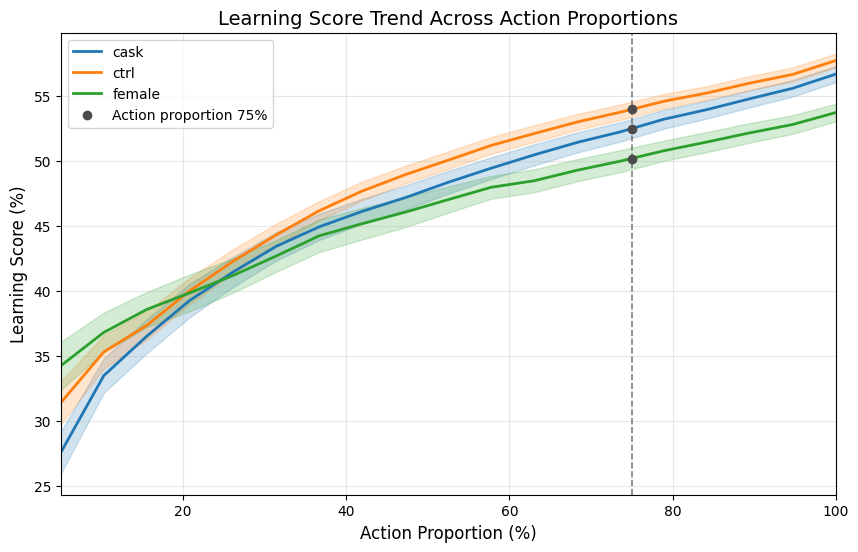

cask Size: 23 	 Average: 73.581 	 SE: 0.753
ctrl Size: 27 	 Average: 72.431 	 SE: 0.733
female Size: 20 	 Average: 67.386 	 SE: 1.102


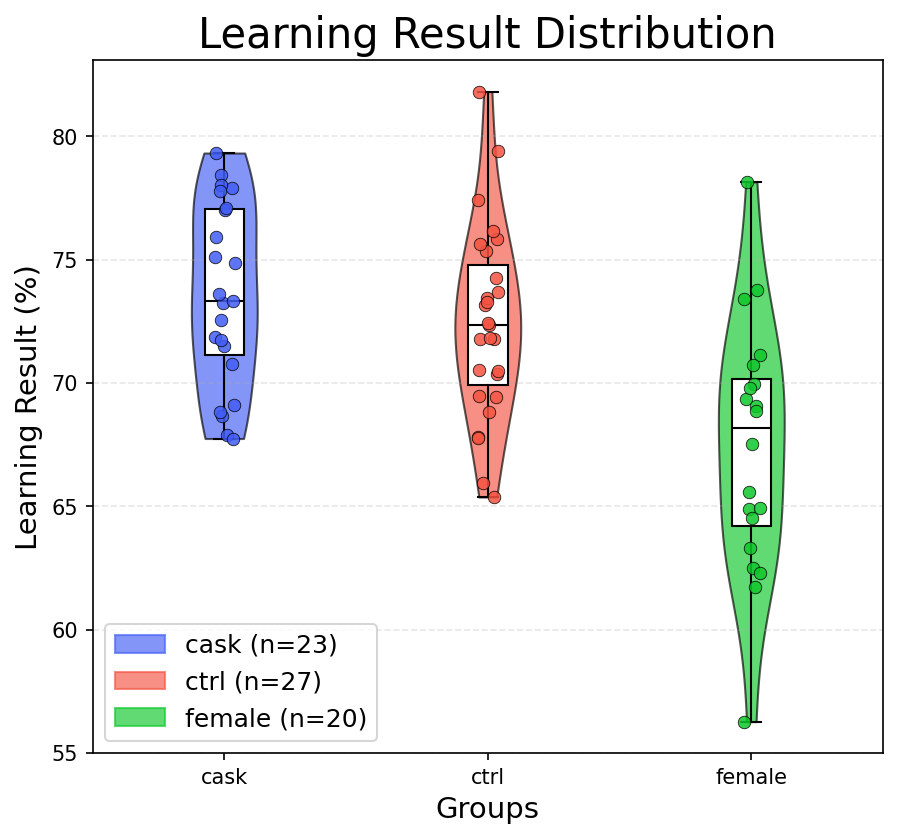

cask Size: 24 	 Average: 0.898 	 SE: 0.007
ctrl Size: 27 	 Average: 0.836 	 SE: 0.008
female Size: 20 	 Average: 0.785 	 SE: 0.016


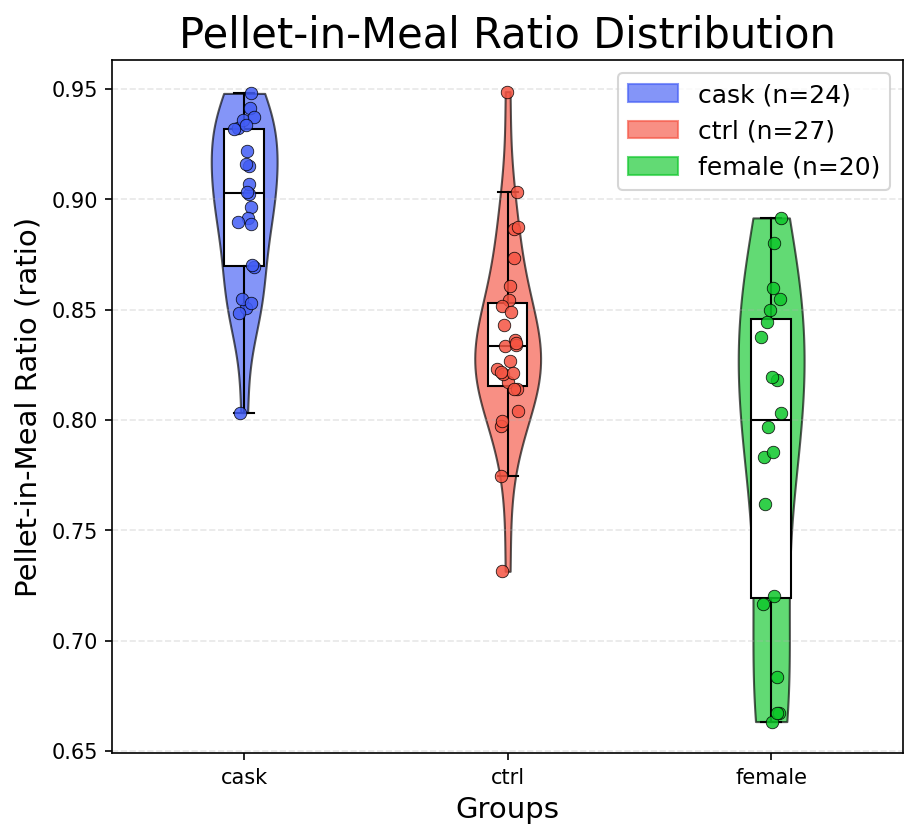

[T-test] Learning Score: cask vs ctrl
P Value is  0.1256352998407167
[T-test] Learning Result: cask vs ctrl
P Value is  0.6105351869784545


In [12]:
plot_learning_score_trend(
    blocks_groups=[rev_blocks[g] for g in GROUPS],
    group_labels=GROUPS,
    block_prop=1.0,
    action_prop=0.75,
    export_path=str(rev_figure_dir / "rev_learning_score_overall.svg"),
)
plot_group_stats_wrapper(rev_learning_results, "Learning Result", "%", "rev_learning_result.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_pellet_ratio_trend(
    blocks_groups=[rev_blocks[g] for g in GROUPS],
    group_labels=GROUPS,
    export_path=str(rev_figure_dir / "rev_pellet_ratio_overall.svg"),
)

run_pairwise_tests(rev_learning_scores, "Learning Score", TEST_PAIRS)
run_pairwise_tests(rev_learning_results, "Learning Result", TEST_PAIRS)

## Step 13: Analyze Pellet Retrieval Times

**Pellet retrieval time** is the duration between poke and pellet collection - a measure of motivation and motor performance.

**This cell computes**:
1. **Mean retrieval time per block**: Average across all pellets in each block (outliers >3 std removed)
2. **Linear trend**: Fits a line through block means to see if retrieval speeds up/slows over time
3. **Projected retrieval time**: Extrapolates the trend to predict performance at session end
4. **Slope**: Rate of change in retrieval speed

For each mouse, generates a plot showing:
- Mean retrieval time per block (blue line with star markers)
- Best-fit linear trend (orange dashed line)
- Slope annotation

**Outputs**:
- `rev_retrieval_mean`: Average retrieval times per mouse
- `rev_retrieval_pred`: Projected final retrieval times
- `rev_retrieval_slope`: Trends (negative = getting faster)
- Individual plots saved to `figures/REV/retrieval/`


## Step 14: Visualize and Test Retrieval Time Metrics

Creates group-level statistical comparisons of retrieval time metrics:

**Three plots generated**:
1. **Mean retrieval time**: Average across all blocks
2. **Projected retrieval time**: Linear extrapolation to end of session  
3. **Retrieval time slope**: Rate of change (negative = improving speed)

**Statistical tests**: T-tests comparing retrieval dynamics between groups.

These metrics help identify whether groups differ in:
- Overall motivation/motor speed
- Trajectory of performance improvement
- Consistency across blocks


In [13]:
rev_retrieval_mean = {g: [] for g in rev_group_sessions}
rev_retrieval_pred = {g: [] for g in rev_group_sessions}
rev_retrieval_slope = {g: [] for g in rev_group_sessions}

retrieval_dir = rev_figure_dir / "retrieval"
retrieval_dir.mkdir(parents=True, exist_ok=True)

for group, sessions in rev_group_sessions.items():
    for session in sessions:
        blocks = split_data_to_blocks(session.raw.copy(), day=REV_DAY_LIMIT)
        block_means, pred, slope = block_retrieval_summary(blocks)
        if not block_means:
            continue
        rev_retrieval_mean[group].append(float(np.mean(block_means)))
        rev_retrieval_pred[group].append(pred)
        rev_retrieval_slope[group].append(slope)

        export_path = retrieval_dir / f"{group.lower()}_{session.key.session_id}_retrieval.svg"
        plot_retrieval_time_by_block(
            block_means,
            mouse_label=session.key.mouse_id,
            group_label=group,
            export_path=export_path,
            show=False,
        )

**Plots generated**:
1. **Retrieval Time Mean**
2. **Retrieval Time Regression Projected Last Value**
3. **Retrieval Time Regression Line Slope**

**Statistical comparisons**: T-tests between group pairs for each metric.

All figures saved to `figures/REV/`.

cask Size: 24 	 Average: 2.556 	 SE: 0.276
ctrl Size: 25 	 Average: 1.851 	 SE: 0.163
female Size: 19 	 Average: 4.174 	 SE: 0.397


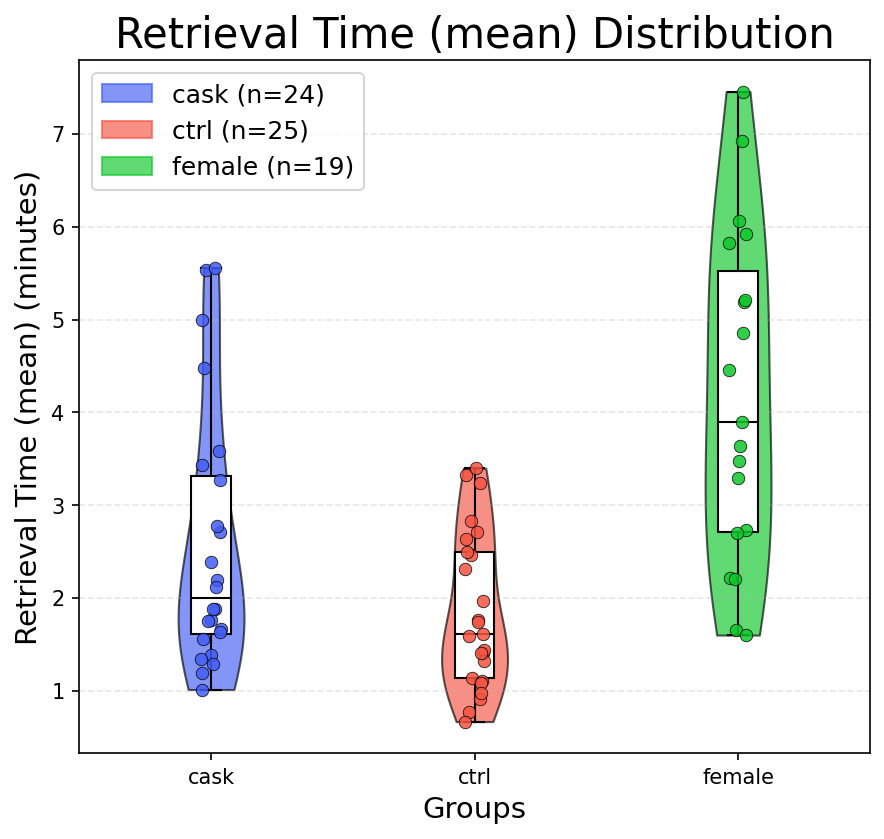

cask Size: 24 	 Average: 2.204 	 SE: 0.406
ctrl Size: 26 	 Average: 1.531 	 SE: 0.337
female Size: 19 	 Average: 2.857 	 SE: 0.681


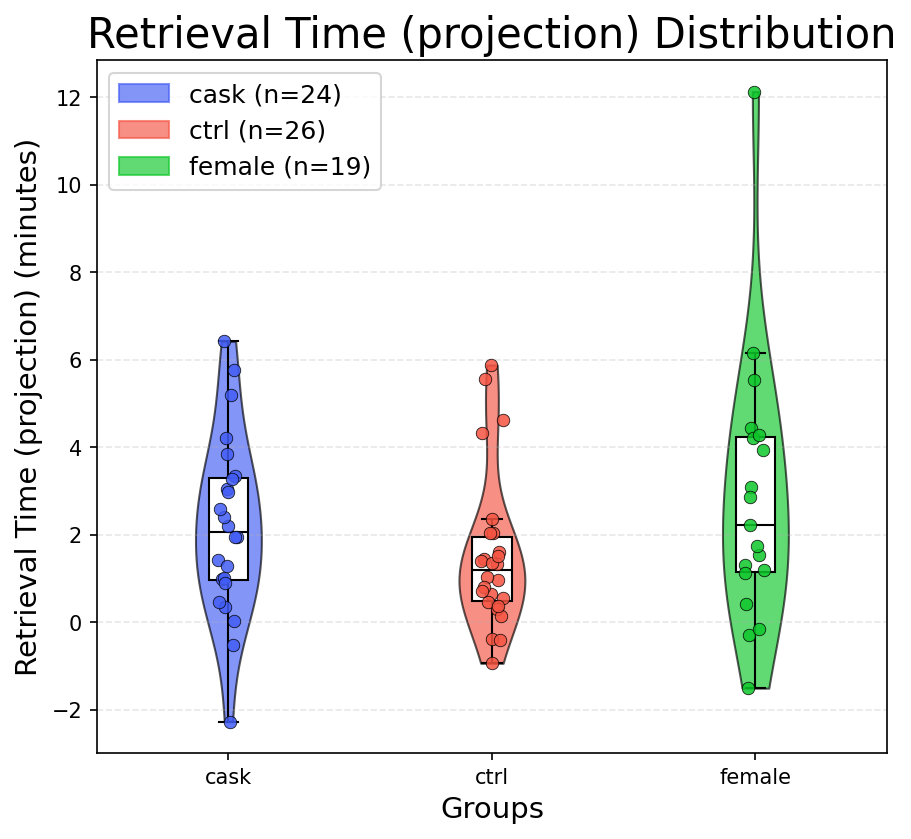

cask Size: 23 	 Average: -0.011 	 SE: 0.020
ctrl Size: 26 	 Average: -0.028 	 SE: 0.022
female Size: 20 	 Average: -0.086 	 SE: 0.064


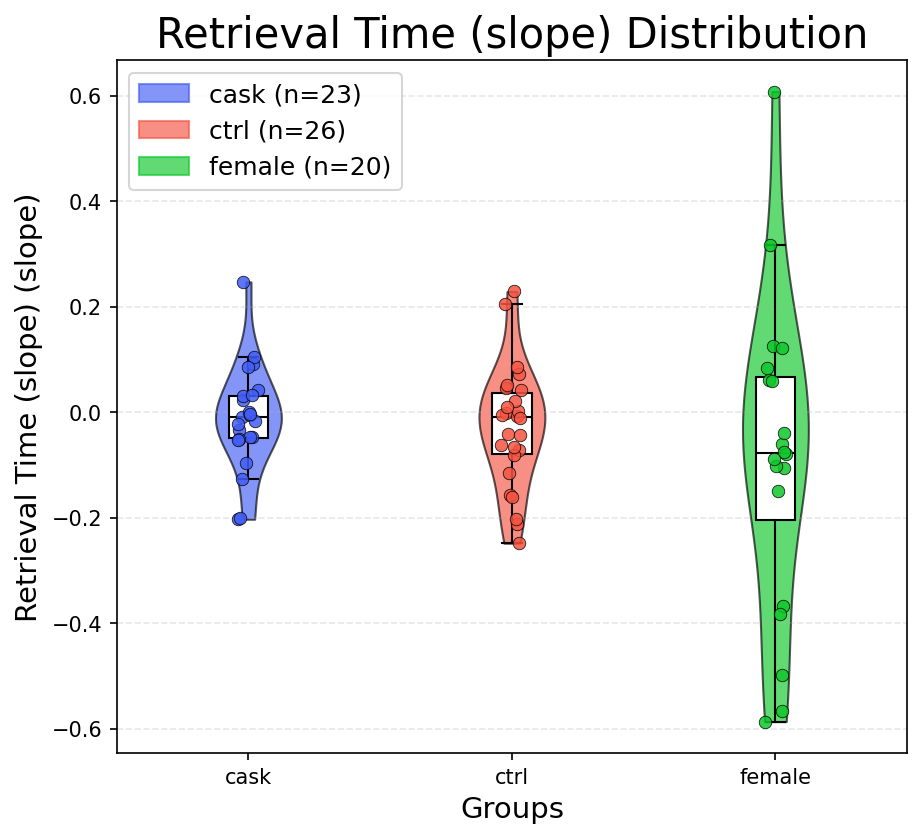

[T-test] Retrieval Time (mean): cask vs ctrl
P Value is  0.45581000180821174
[T-test] Retrieval Time (projection): cask vs ctrl
P Value is  0.4743755381867111
[T-test] Retrieval Time (slope): cask vs ctrl
P Value is  0.6362323907419827


In [14]:
plot_group_stats_wrapper(rev_retrieval_mean, "Retrieval Time (mean)", "minutes", "rev_retrieval_mean.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_retrieval_pred, "Retrieval Time (projection)", "minutes", "rev_retrieval_projection.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_retrieval_slope, "Retrieval Time (slope)", "slope", "rev_retrieval_slope.svg", rev_figure_dir, remove_outlier_stds=2.5)

run_pairwise_tests(rev_retrieval_mean, "Retrieval Time (mean)", TEST_PAIRS)
run_pairwise_tests(rev_retrieval_pred, "Retrieval Time (projection)", TEST_PAIRS)
run_pairwise_tests(rev_retrieval_slope, "Retrieval Time (slope)", TEST_PAIRS)

## Step 15: Analyze Reversal Meal Patterns

Just like FR1, we analyze meal patterns during reversal sessions to understand feeding behavior under cognitive challenge.

**For each reversal session, this computes**:
1. **Average pellets per hour**: Overall consumption rate
2. **First meal time**: Initial feeding latency  
3. **First good meal time**: Latency to quality feeding (ML-classified)
4. **Inactive meal fraction**: Proportion of meals during inactive periods
5. **In-meal pellet ratio**: Organized vs scattered eating
6. **Good meal proportion**: Ratio of good to bad meals

**Generates**:
- Metric dictionaries organized by group
- Per-session plots in `figures/REV/meals/`
- Group-level statistical visualizations and t-tests

This reveals whether reversal stress affects feeding organization and efficiency.


cask Size: 24 	 Average: 225.547 	 SE: 5.475
ctrl Size: 26 	 Average: 193.315 	 SE: 4.177
female Size: 19 	 Average: 188.587 	 SE: 6.435


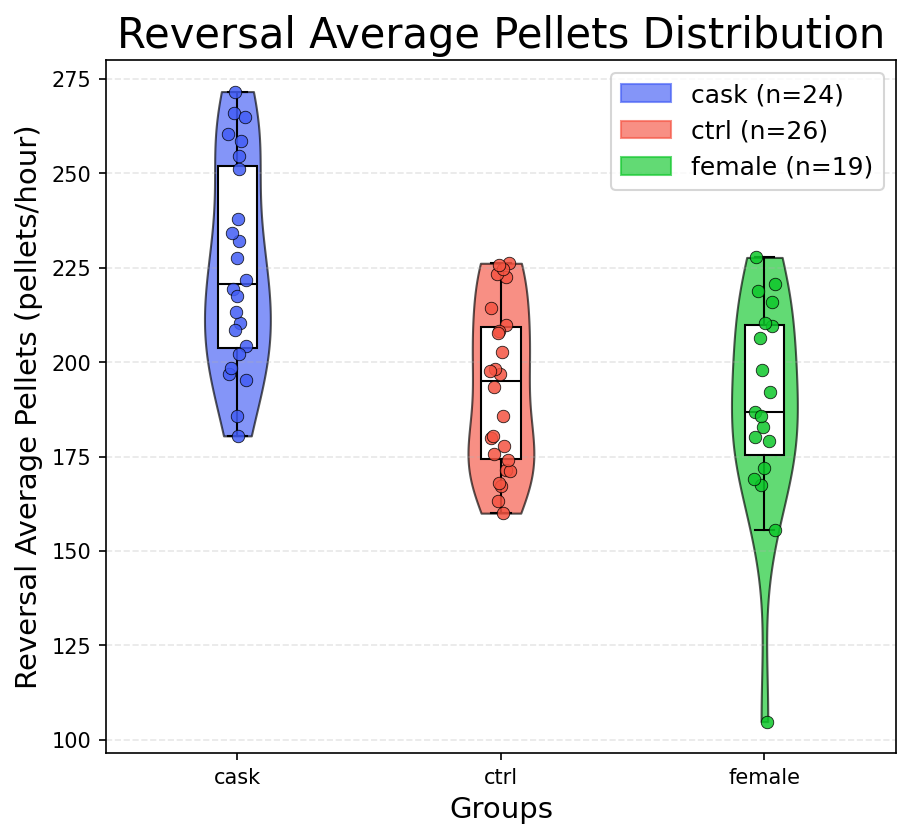

cask Size: 23 	 Average: 1.043 	 SE: 0.153
ctrl Size: 26 	 Average: 0.828 	 SE: 0.118
female Size: 19 	 Average: 1.646 	 SE: 0.213


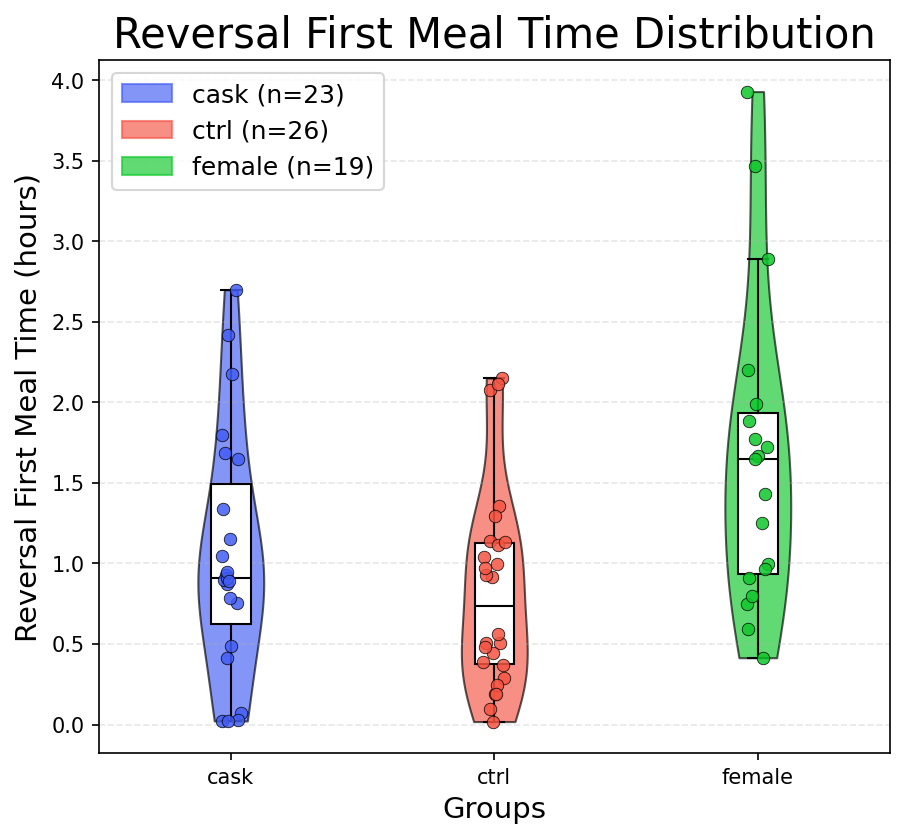

cask Size: 23 	 Average: 1.697 	 SE: 0.231
ctrl Size: 26 	 Average: 1.372 	 SE: 0.201
female Size: 19 	 Average: 2.287 	 SE: 0.224


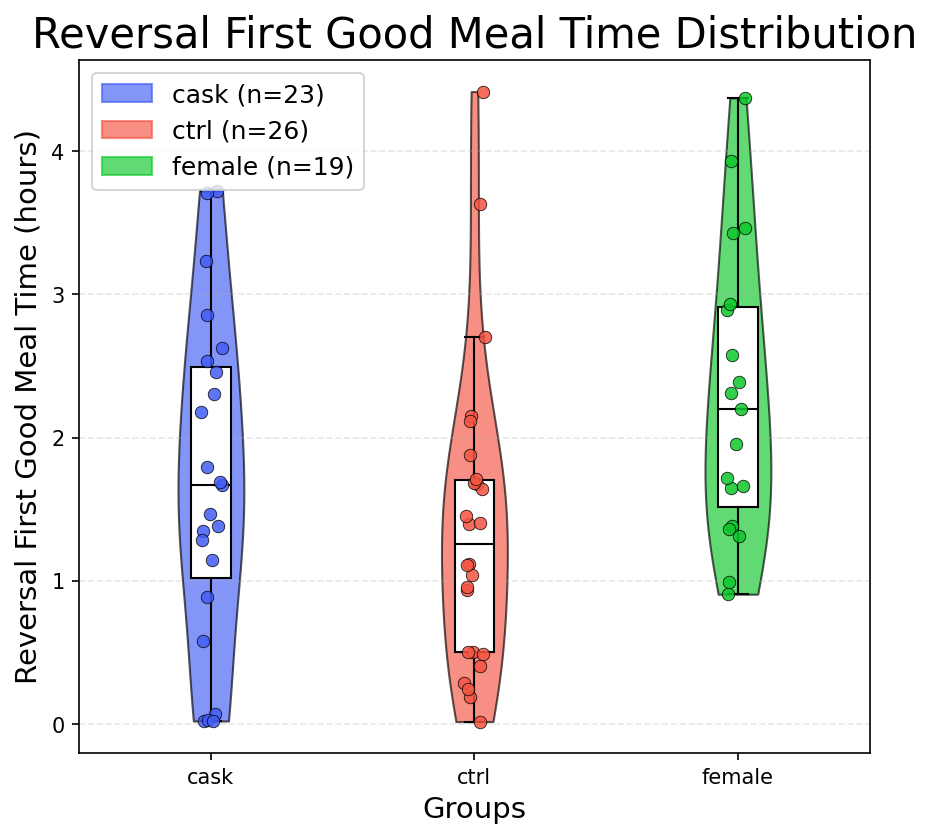

cask Size: 24 	 Average: 0.425 	 SE: 0.031
ctrl Size: 26 	 Average: 0.582 	 SE: 0.019
female Size: 20 	 Average: 0.479 	 SE: 0.022


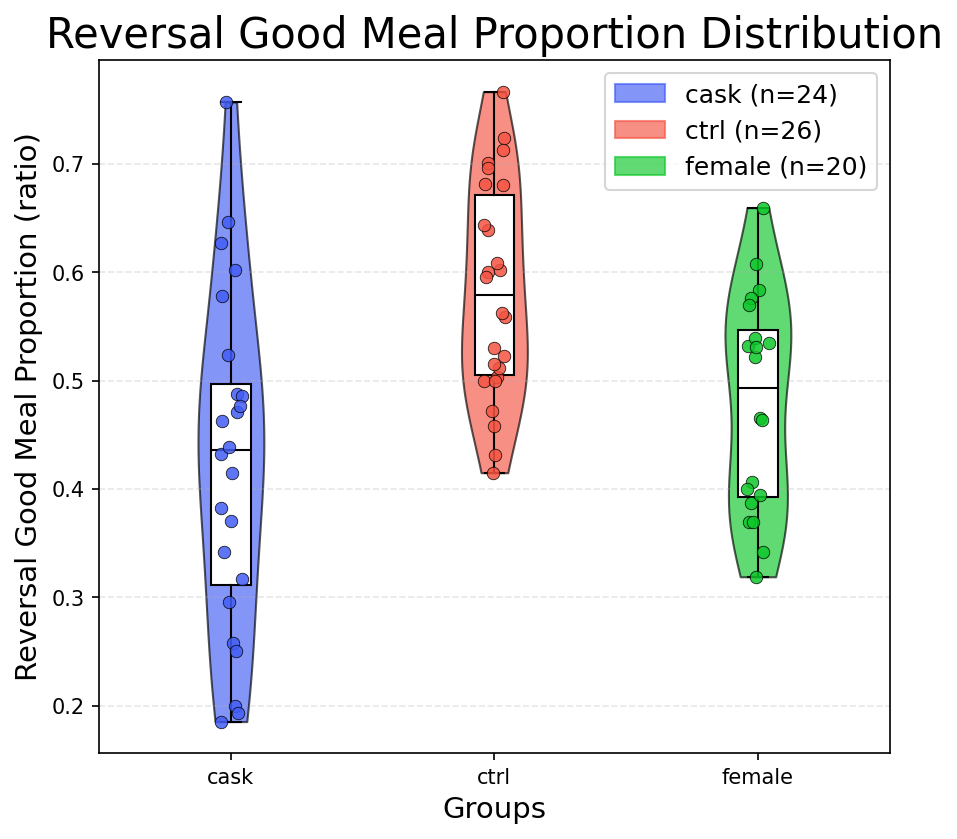

cask Size: 24 	 Average: 0.286 	 SE: 0.010
ctrl Size: 26 	 Average: 0.299 	 SE: 0.017
female Size: 19 	 Average: 0.320 	 SE: 0.019


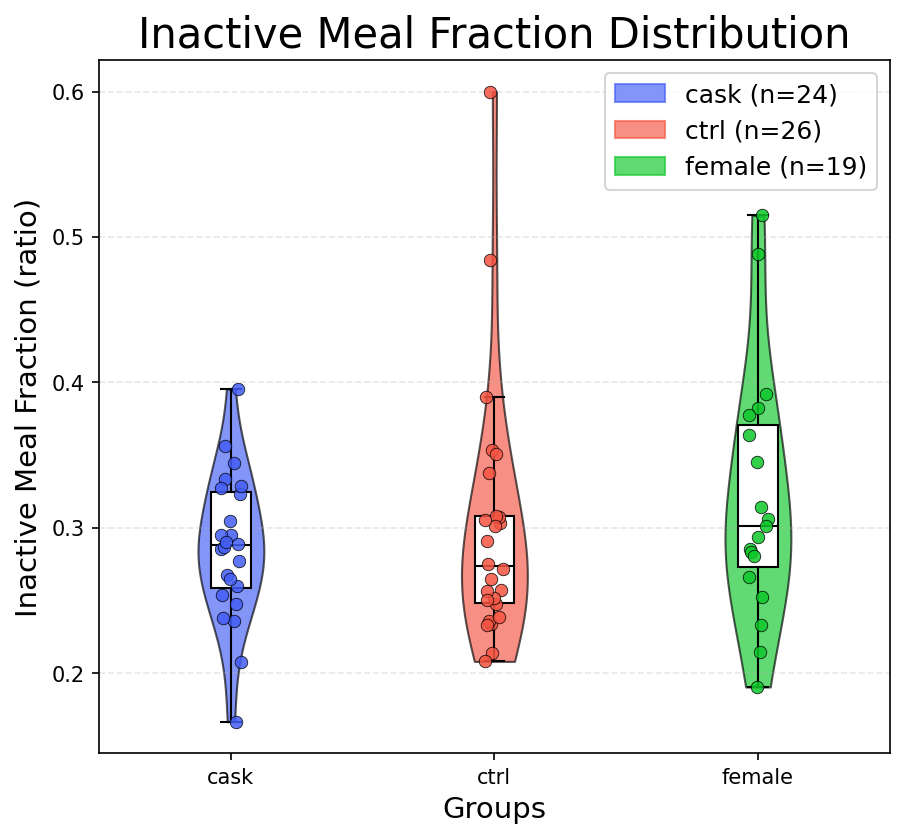

cask Size: 24 	 Average: 0.636 	 SE: 0.014
ctrl Size: 27 	 Average: 0.612 	 SE: 0.012
female Size: 20 	 Average: 0.511 	 SE: 0.012


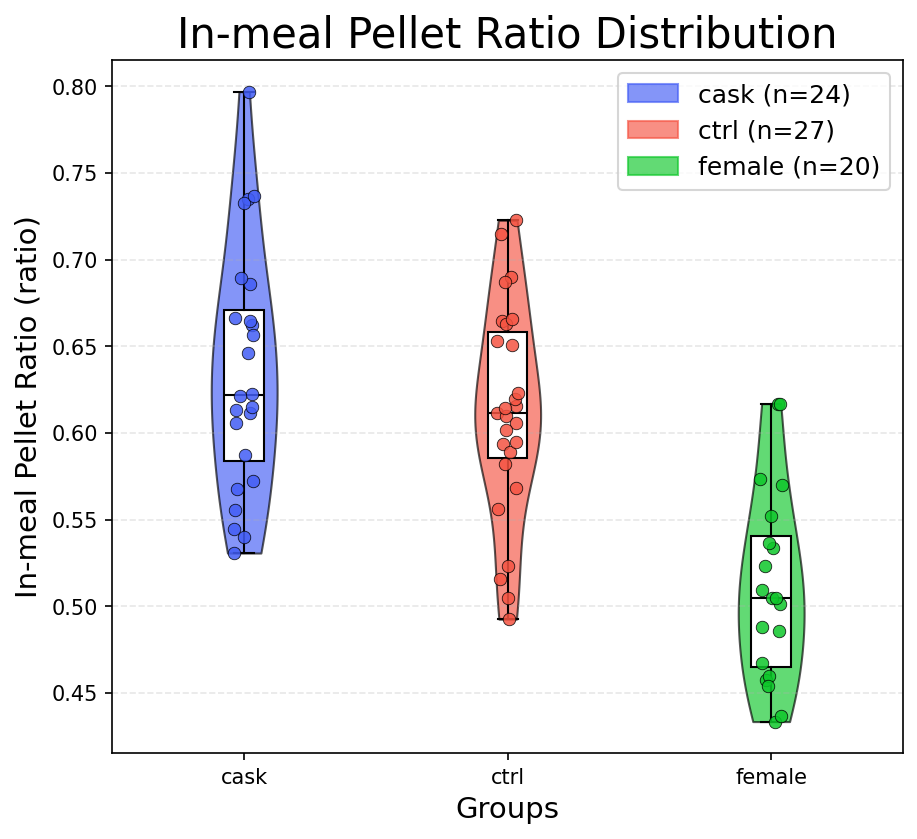

[T-test] Reversal Average Pellets: cask vs ctrl
P Value is  5.185386777569849e-05
[T-test] Reversal First Meal Time: cask vs ctrl
P Value is  0.27288439488456306
[T-test] Reversal First Good Meal Time: cask vs ctrl
P Value is  0.83501656815976
[T-test] Inactive Meal Fraction: cask vs ctrl
P Value is  0.2748433653192888
[T-test] In-meal Pellet Ratio: cask vs ctrl
P Value is  0.2053340995075969
[T-test] Reversal Good Meal Proportion: cask vs ctrl
P Value is  0.0009816640567062145


In [15]:
rev_meal_dir = rev_figure_dir / "meals"
rev_meal_dir.mkdir(parents=True, exist_ok=True)

rev_meal_metrics = {group: [] for group in rev_group_sessions}
rev_meal_quality = {group: [] for group in rev_group_sessions}
for group, sessions in rev_group_sessions.items():
    for session in sessions:
        metrics = process_meal_data(session, export_root=rev_meal_dir)
        rev_meal_metrics[group].append(metrics)
        rev_meal_quality[group].append({
            'good_mask': metrics.get('good_mask'),
            'total_meals': metrics.get('total_meals'),
        })

rev_avg_pellet = collect_metric("avg_pellet", rev_meal_metrics)
rev_first_meal = collect_metric("fir_meal", rev_meal_metrics)
rev_first_good = collect_metric("fir_good_meal", rev_meal_metrics)
rev_inactive = collect_metric("inactive_meals", rev_meal_metrics)
rev_in_meal_ratio = collect_metric("in_meal_ratio", rev_meal_metrics)
rev_good_meal_ratio = collect_good_meal_ratio(rev_meal_quality)

plot_group_stats_wrapper(rev_avg_pellet, "Reversal Average Pellets", "pellets/hour", "rev_avg_pellet.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_first_meal, "Reversal First Meal Time", "hours", "rev_first_meal_time.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_first_good, "Reversal First Good Meal Time", "hours", "rev_first_good_meal_time.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_good_meal_ratio, "Reversal Good Meal Proportion", "ratio", "rev_good_meal_ratio.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_inactive, "Inactive Meal Fraction", "ratio", "rev_inactive_meals.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats_wrapper(rev_in_meal_ratio, "In-meal Pellet Ratio", "ratio", "rev_in_meal_ratio.svg", rev_figure_dir, remove_outlier_stds=2.5)

run_pairwise_tests(rev_avg_pellet, "Reversal Average Pellets", TEST_PAIRS)
run_pairwise_tests(rev_first_meal, "Reversal First Meal Time", TEST_PAIRS)
run_pairwise_tests(rev_first_good, "Reversal First Good Meal Time", TEST_PAIRS)
run_pairwise_tests(rev_inactive, "Inactive Meal Fraction", TEST_PAIRS)
run_pairwise_tests(rev_in_meal_ratio, "In-meal Pellet Ratio", TEST_PAIRS)
run_pairwise_tests(rev_good_meal_ratio, "Reversal Good Meal Proportion", TEST_PAIRS)